# **TikTok Claims Classification Project: Random Forest/XGBoost Models**

<img src="..\Images\Bubble logo.png" alt="Logo" style="float:left; width:120px; height:120px;">

## **Introduction**

This notebook focuses on building and evaluating two predictive models, Random Forest and XGBoost, to classify TikTok videos as either claims or opinions. The objective is to support TikTok's content moderation process by prioritizing user reports more efficiently, helping reduce backlogs and ensuring harmful or misleading content is addressed promptly.

The primary performance metric is Recall (Sensitivity) for the "claim" class, minimizing the risk of false negatives to prevent misleading claims from being overlooked. Supporting metrics, such as Precision and F1 Score, will ensure flagged claims are accurate and the balance between precision and recall is optimized. 

Ethical considerations, including bias, transparency, and the consequences of model errors, are essential to ensure fair and responsible implementation. Maintaining fairness and transparency is critical for building trust in TikTok’s content moderation system, as a model that operates without bias and provides clear insights into its decisions reinforces TikTok's reputation for ethical content management while minimizing potential conflicts or challenges from users and moderators.

## **Contents**

#### **Setup and Initialization**

1. Import Libraries and Packages
2. Load Preprocessed Dataset
3. Confirm Dataset is Correct

#### **Model Development**

4. Feature Selection
5. Create train/Validate/Test Sets
6. Build and Train Random Forest Model
7. Build and Train XGBoost Model

#### **Model Evaluation**

8. Evaluate Model Performance Against Validation Data
9. Use Champion Model on Test Data
10. Conclusion

<br>

# **Setup and Initionalization**
## **1. Import Libraries and Packages**

**Import** necessary libraries for data manipulation, visualization, and modelling.

In [107]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# Display all columns by preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

<br>

## **2. Load Preprocessed Dataset**

**Load** the preprocessed dataset into a DataFrame for model development.

In [25]:
# Read in dataset
data_cleaned = pd.read_csv(r'C:\Users\danet\Documents\cleaned_tiktok_dataset.csv')

<br>

## **3. Confirm Dataset is Correct**

**Inspect** first few rows.

In [26]:
data_cleaned.head(3)

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False


<br>

**View** basic information about the data.

In [27]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084 entries, 0 to 19083
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   claim_status                    19084 non-null  int64  
 1   video_duration_sec              19084 non-null  int64  
 2   video_transcription_text        19084 non-null  object 
 3   video_view_count                19084 non-null  float64
 4   video_like_count                19084 non-null  float64
 5   video_share_count               19084 non-null  float64
 6   video_download_count            19084 non-null  float64
 7   video_comment_count             19084 non-null  float64
 8   text_length                     19084 non-null  int64  
 9   verified_status_verified        19084 non-null  bool   
 10  author_ban_status_banned        19084 non-null  bool   
 11  author_ban_status_under review  19084 non-null  bool   
dtypes: bool(3), float64(5), int64(3)

<br>

# **Model Development**

## **4. Feature Selection**

**Create** a copy of the dataset.

In [28]:
# Create a copy for the X data
X = data_cleaned.copy()

<br>

**Assign** target variable.

In [29]:
# Isolate target variable
y = X['claim_status']

<br>

**Isolate** the feature variables.

In [30]:
# Isolate features
X = X.drop(['claim_status', 'video_transcription_text'], axis=1)

# Display first few rows of features dataframe
print(f"Rows    : {X.shape[0]}")
print(f"Columns : {X.shape[1]}")
X.head()

Rows    : 19084
Columns : 10


,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


<br>

## **5. Create Train/Validate/Test Sets**

**Split** data into training and testing sets, 80/20.

In [31]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<br>

**Split** the training set into a 75/25 ratio for training and validation, achieving a final dataset distribution of 60/20/20 for training, validation, and testing.

In [32]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

<br>

**Ensure** that the dimensions of the training, validation, and testing sets are correctly aligned.

In [33]:
# Get shape of each training, validation, and testing set
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(11450, 10) (3817, 10) (3817, 10) (11450,) (3817,) (3817,)


***Note:*** 

* The dataset is split into 60% (11,450 samples) for training and 20% (3,817 samples) each for validation and testing.
* Each set contains 10 features/columns for model input.
* The alignment of data splits ensures consistency for training, validation, and testing phases.

<br>

# **6. Build and Train Random Forest Model**

**Train** a Random Forest model on the training set, utilizing cross-validation to tune hyperparameters and identify the model that optimizes recall performance.

In [43]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
rf_cv_params = {'max_depth': [5, 7, None], 
             'max_features': [0.3, 0.6], 
             'max_samples': [0.5, 0.7, 1.0], 
             'min_samples_leaf': [1, 2], 
             'min_samples_split': [2, 3], 
             'n_estimators': [75, 100, 200] 
             }

# Define a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',  # Using predefined metric name
    'precision': make_scorer(precision_score, average='binary', zero_division=1),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, rf_cv_params, scoring=scoring, cv=5, refit='recall')

In [44]:
%%time
# Fit the model
rf_cv.fit(X_train, y_train)

CPU times: total: 10min 40s
Wall time: 10min 48s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.5, 0.7, 1.0],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall',
             scoring={'accuracy': 'accuracy',
                      'f1': make_scorer(f1_score, response_method='predict', average=binary),
                      'precision': make_scorer(precision_score, response_method='predict', average=binary, zero_division=1),
                      'recall': make_scorer(recall_score, response_method='predict', average=binary)})

**Note:** 

In [46]:
# Get all the results from the CV and put them in a df
cv_results_df = pd.DataFrame(rf_cv.cv_results_)
cv_results_df.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.195402,0.009152,0.008217,0.000478,5,0.3,0.5,1,2,75,"{'max_depth': 5, 'max_features': 0.3, 'max_sam...",0.996943,0.995197,0.995197,0.99607,0.991703,0.995022,0.001781,116,0.998268,1.0,1.0,1.0,0.999124,0.999479,0.000694,15,0.995682,0.990509,0.990509,0.992235,0.984469,0.990681,0.003635,107,0.996974,0.995232,0.995232,0.996102,0.991743,0.995056,0.001778,117


In [47]:
# Isolate the row of the df with the max(mean precision score)
best_precision_row_df = cv_results_df.loc[[cv_results_df['mean_test_precision'].idxmax()]]

# Display the row
best_precision_row_df['mean_test_precision']

13    0.999652
Name: mean_test_precision, dtype: float64

In [48]:
# Examine best recall score
rf_cv.best_score_

np.float64(0.991026002107111)

In [49]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.3,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 75}

<br>

# **7. Build and Train XGBoost Model**

**Train** an XGBoost model on the training set, leveraging cross-validation to tune hyperparameters and select the model that maximizes recall performance.

In [106]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
xgb_cv_params = {'max_depth': [3, 5, 7, 10], 
             'min_child_weight': [3, 5], 
             'learning_rate': [0.01, 0.1, 0.2], 
             'n_estimators': [100, 300, 500] 
             }

# Define a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',  # Using predefined metric name
    'precision': make_scorer(precision_score, average='binary', zero_division=1),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, xgb_cv_params, scoring=scoring, cv=5, refit='recall')

In [69]:
%%time
# Fit the model
xgb_cv.fit(X_train, y_train)

CPU times: total: 15min 56s
Wall time: 49.5 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                         'max_depth': [3, 5, 7, 10], 'min_child_weight': [3, 5],
                         'n_estimators': [100, 300, 500]},
             refit='recall',
             scoring={'accuracy': 'accuracy',
                      'f1': make_scorer(f1_score, response_method='predict', average=binary),
                      'precision': make_scorer(precision_score, response_method='predict', average=binary, zero_division=1),
                      'recall': make_scorer(recall_score, response_method='predict', average=binary)})

In [70]:
# Get all the results from the CV and put them in a df
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)
xgb_results_df.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.050817,0.005093,0.008081,0.000991,0.01,3,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'min_c...",0.995633,0.992576,0.99476,0.995633,0.98952,0.993624,0.002337,58,1.0,1.0,1.0,1.0,0.995633,0.999127,0.001747,37,0.991364,0.985332,0.989646,0.991372,0.983607,0.988264,0.003208,60,0.995663,0.992612,0.994796,0.995667,0.989583,0.993664,0.002326,60


In [71]:
# Isolate the row of the df with the max(mean precision score)
xgb_precision_row_df = xgb_results_df.loc[[xgb_results_df['mean_test_precision'].idxmax()]]

# Display the row
xgb_precision_row_df['mean_test_precision']

2    1.0
Name: mean_test_precision, dtype: float64

In [72]:
# Examine best recall score
xgb_cv.best_score_

np.float64(0.9898176171763818)

In [73]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 300}

<br>

# **Model Evaluation**

## **8. Evaluate Model Performance Against Validation Data**

#### **Random Forest**

In [74]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
rf_y_pred = rf_cv.best_estimator_.predict(X_val)

In [75]:
# Display the predictions on the encoded testing set
rf_y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [76]:
# Display the true labels of the testing set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

<br>

**Confusion Matrix** to visualize the results of the classification model.

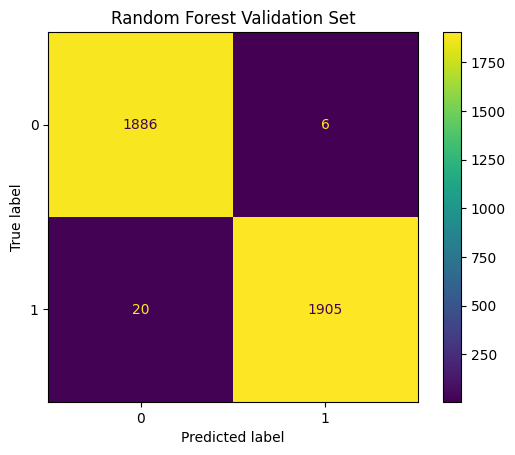

In [77]:
# Compute values for confusion matrix
rf_log_cm = confusion_matrix(y_val, rf_y_pred)

# Create display of confusion matrix
rf_log_disp = ConfusionMatrixDisplay(confusion_matrix=rf_log_cm, display_labels=None)

# Plot confusion matrix
rf_log_disp.plot(values_format="d")

# Display plot
plt.title('Random Forest Validation Set')
plt.show()

<br> 

**Classification Report** that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [78]:
# Create classification report for random forest model
rf_target_labels = ['opinion', 'claim']
print(classification_report(y_val, rf_y_pred, target_names=rf_target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



#### **Summary:**

**Confusion Matrix (Random Forest)**

* True Positives (Correct predictions):
    * 1886 for class opinion (top-left)
    * 1905 for class claim (bottom-right)  
* False Positives and False Negatives (Errors):
    * Only 6 false positives (claim misclassified as opinion).
    * Only 20 false negatives (opinion misclassified as claim).
    
**Classification Report (Random Forest)**

* High performance: The precision, recall, and F1-score for both classes (opinion and claim) are all 0.99, indicating the model is nearly perfect in distinguishing between these two labels.
* Balanced results: Macro and weighted averages also show 0.99, reflecting consistency across both classes.
* Accuracy: The model achieved an overall accuracy of 99%, which is exceptional.

**Business Takeaway**  
This Random Forest model demonstrates outstanding performance with minimal misclassifications. This level of accuracy and balance ensures reliable predictions, making it a robust choice for decision-making.

<br>

#### **XGBoost Model**

In [97]:
# Evaluate XGBoost model
xgb_y_pred = xgb_cv.best_estimator_.predict(X_val)

<br>

**Confusion Matrix** to visualize the results of the classification model.

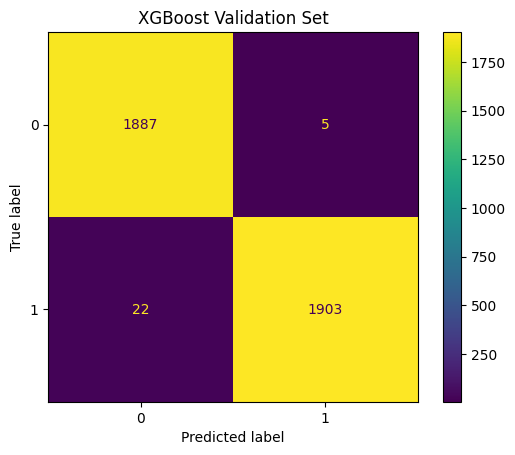

In [83]:
# Compute values for confusion matrix
xgb_log_cm = confusion_matrix(y_val, xgb_y_pred)

# Create display of confusion matrix
xgb_log_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_log_cm, display_labels=None)

# Plot confusion matrix
xgb_log_disp.plot(values_format="d")

# Display plot
plt.title('XGBoost Validation Set');
plt.show()

<br> 

**Classification Report** that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [84]:
# Create a classification report
xgb_target_labels = ['opinion', 'claim']
print(classification_report(y_val, xgb_y_pred, target_names=xgb_target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



#### **Summary:**

**Confusion Matrix (XGBoost)**
* True Positives (Correct predictions):
    * 1887 for class opinion (top-left)
    * 1903 for class claim (bottom-right)
* False Positives and False Negatives (Errors):
    * Only 5 false positives (claim misclassified as opinion).
    * Only 22 false negatives (opinion misclassified as claim).
    

**Classification Report (XGBoost)**

* High performance: The opinion class achieves 0.99 (precision), 1.00 (recall), and 0.99 (F1-score). The claim class achieves 1.00 (precision), 0.99 (recall), and 0.99 (F1-score).
* Balanced results: Both macro and weighted averages show 0.99, indicating consistency in performance across classes.
* Accuracy: Overall accuracy is 99%, identical to the Random Forest model.

**Business Takeaway**  
The XGBoost model demonstrates excellent performance with extremely low error rates, just like the Random Forest model.

**Model Comparison**  
Both models perform exceptionally well with near-identical metrics; however, Random Forest edges out as the champion model due to slightly better recall for the claim class and fewer false negatives (20 vs. 22). This aligns more closely with our goal of accurately identifying claims to prevent harmful or misleading content from being overlooked.

<br>

## **9. Use Champion Model on Test Data**

In [98]:
# Evaluate Champion model
y_pred = rf_cv.best_estimator_.predict(X_test)

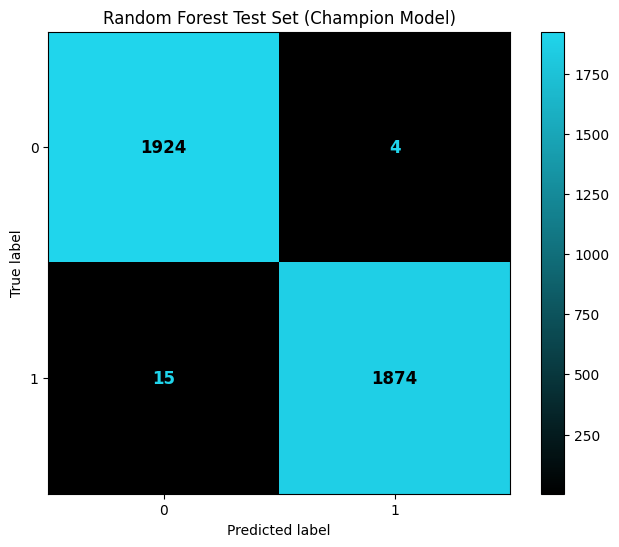

In [105]:
from matplotlib.colors import LinearSegmentedColormap

# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Define custom colormap using your colour scheme
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#000000", "#20D5EC"])

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix with custom colourmap
fig, ax = plt.subplots(figsize=(8, 6))
log_disp.plot(cmap=custom_cmap, ax=ax, text_kw={'fontsize': 12, 'fontweight': 'bold'})

# Customize plot title and display
plt.title('Random Forest Test Set (Champion Model)')
plt.show()

<br>

#### **Feature Importances of Champion Model**

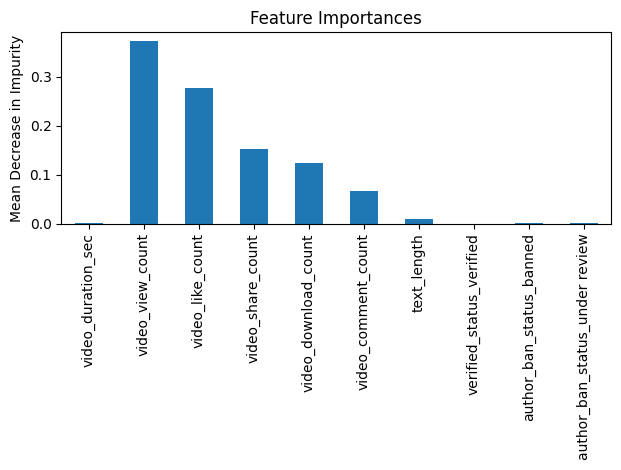

In [99]:
# Plot feature importance
importances = rf_cv.best_estimator_.feature_importances_ 
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature Importances')
ax.set_ylabel('Mean Decrease in Impurity')
fig.tight_layout()

#### **Summary:**

The most predictive features for distinguishing claims from opinions are video engagement metrics, including views, likes, shares, downloads, and comments. Surprisingly, verified status and author ban status had little influence, despite their assumed relevance to credibility. This highlights the importance of audience interaction over user attributes in classification.

**Key Points:**  
* **Top features:** Video view count, like count, and share count.
* **Text length:** Provides some predictive value but less impactful than engagement metrics.
* **Surprising finding:** Verified and author ban statuses contribute minimally.
* **Takeaway:** Focus on engagement metrics to enhance future models.

<br>

#### **Model Comparison**

In [96]:
# Create a dictionary of metrics for Random Forest and XGBoost
metrics_data = {
    'Model': ['Random Forest', 'XGBoost', 'Champion'],
    'Accuracy': [accuracy_score(y_val, rf_y_pred), 
                 accuracy_score(y_val, xgb_y_pred),
                 accuracy_score(y_test, y_pred)],
    'Precision': [precision_score(y_val, rf_y_pred, average='binary'),
                  precision_score(y_val, xgb_y_pred, average='binary'),
                  precision_score(y_test, y_pred, average='binary')],
    'Recall': [recall_score(y_val, rf_y_pred, average='binary'),
               recall_score(y_val, xgb_y_pred, average='binary'),
               recall_score(y_test, y_pred, average='binary')],
    'F1 Score': [f1_score(y_val, rf_y_pred, average='binary'),
                 f1_score(y_val, xgb_y_pred, average='binary'),
                 f1_score(y_test, y_pred, average='binary')]
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.993188,0.996860,0.989610,0.993222
1,XGBoost,0.992926,0.997379,0.988571,0.992956
2,Champion,0.995022,0.997870,0.992059,0.994956


<br>

## **10. Conclusion**

The champion model performed exceptionally well on both the validation and test datasets, achieving consistently high metrics for accuracy (99.50%), precision (99.79%), recall (99.21%), and F1 score (99.50%). This indicates its effectiveness in accurately classifying TikTok videos as claims or opinions, minimizing both false negatives and false positives.

**Key insights from the model include:**

* **Feature Importance:** The model primarily relied on engagement metrics like video view count, like count, share count, and download count, which were the strongest predictors of claims versus opinions. Conversely, features such as verification status and author ban status had minimal impact on predictions, defying initial assumptions.
* **Error Analysis:** With only 15 false negatives and 4 false positives on the test set, the model effectively balanced recall and precision, meeting the primary goal of accurately identifying claims to prevent harmful content from being overlooked.

**While the model’s performance is nearly perfect, further improvements could be made by integrating additional features, such as:**

* **Early Indicators:** Features like author ID, the number of times a video was reported, and the total user reports for all videos by the same author could provide valuable insights and enhance predictions.
* **Proactive Monitoring:** Ideally, developing a real-time monitoring system to predict content classification before significant engagement accumulates would further strengthen TikTok’s content moderation capabilities.

Overall, this champion model is highly recommended for deployment, as it demonstrates robust and reliable performance, aligns with business objectives, and requires no immediate feature engineering for improvement.